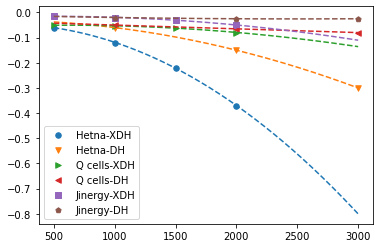

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

file = r'C:\Users\franc\PVcharacterization_files\essai_fit.xlsx'
df = pd.read_excel(file)
df.rename(columns={"Unnamed: 0":"titre0",
                   "Unnamed: 1":"titre1"},
         inplace=True)


titre1_corrige = []
list_titre = df['titre0'].tolist()
for i, titre in enumerate(list_titre): 
    if i%2 == 1:
        titre1_corrige.append(list_titre[i-1])
    else:
        titre1_corrige.append(list_titre[i])      
df['titre0'] = titre1_corrige

x = [float(y[0:-1]) for y in df.columns if 'h' in y]
x_fit = np.linspace(min(x),max(x),200)

marker = ["o", "v", ">", "<", "s", "p"]

for index_row in df.index:
    label = df.iloc[index_row,0]+ '-' + df.iloc[index_row,1]
    y = df.iloc[index_row,[2,3,4,5,6,7]].tolist()
    
    x_for_fit = []
    y_for_fit = []
    for x1, y1, test in zip(x,y,np.isnan(y)):
        if not test:
            x_for_fit.append(x1)
            y_for_fit.append(y1)
    z = np.polyfit(x_for_fit, y_for_fit, 2)
    p = np.poly1d(z)
    plt.scatter(x,y,label=label,marker=marker[index_row],s=30)
    plt.plot(x_fit,p(x_fit),'--')
plt.legend()


,A0,A1,A2
Hetna-XDH,-9.000000e-08,1.900000e-05,-0.04750
Hetna-DH,-3.000000e-08,-5.007143e-20,-0.03000
Q cells-XDH,-1.500000e-08,1.850000e-05,-0.05625
Q cells-DH,1.073247e-23,-1.500000e-05,-0.03500
Jinergy-XDH,-1.500000e-08,1.450000e-05,-0.01875
Jinergy-DH,2.500000e-09,-1.250000e-05,-0.01000


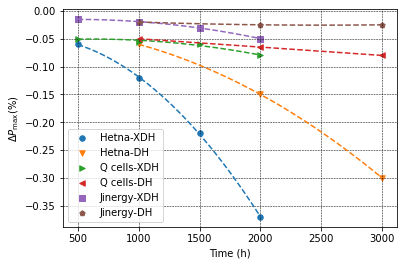

In [7]:
# Standard Library imports
from itertools import cycle
from pathlib import Path

#3rd party import
import matplotlib.pyplot as plt

DEFAULT_DIR = Path.home()
ORDER = 2 # Polynomial order for the regession
list_markers = ["o", "v", ">", "<", "s", "p"] # List of marker for the scatter plot
Nfit = 200 # Number of points to plot the fitting polynomial
file = DEFAULT_DIR / Path('PVcharacterization_files/essai_fit.xlsx')

def read_and_clean(file):
    
    '''
    The read_and_clean function reads an .xlsx file organized as flow:

    ======= ===== ====== ====== =====  ===== ====== ======
                   500h  1000h  1500h  2000h  2500h 3000h
    Hetna   XDH    -6%    -12%   -22%  -37%     
            DH            -6%          -15%         -30%
    Q cells XDH    -5%    -5,50% -6%   -8%
            DH            -5%          -6,50%       -8%
    Jinergy XDH    -1,50% -2%    -3%   -5%
            DH            -2%          -2,50%       -2,50%
    ======= ===== ====== ====== =====  ===== ====== ======
    
    The data are cleaned as follow:
    
    - the missing values of the column are filled as follow Hetna,Hetna,Qcell,Qcell,...
    - for each label Hetna-XDH, Hetna-DH,... the x_clean, y_clean lists are built by retaining
    only the (x_clean, y_clean) tuples where y_clean is not an nan.
    
    Args:
       file (Path): absolute na of the .xlsx file
       
    Returns:
       dic_values (dict): dictionary keyed by label of the named tuples:
                          data_struct.x containing the x clean values
                          data_struct.y containing the y clean values
    
    Examples:
       {'Hetna-XDH':([500,1000,1500,2000],[-6,-12,-22,-37]),
       'Hetna-DH':([1000,2000,3000],[-6,-15,-30]),
       ...}
                          
    '''
    
    # Standard library imports
    from collections import namedtuple
    
    # 3rd party imports
    import pandas as pd

    dic_values = {}
    data_struct = namedtuple("x_y", 
                             ["x",
                              "y",
                             ]
                             )
    
    df = pd.read_excel(file)
    df.rename(columns={"Unnamed: 0":"titre0",
                       "Unnamed: 1":"titre1"},inplace=True)

    # Takes care of the nan in titre0 column
    titre1_corrige = []
    list_titre = df['titre0'].tolist()
    for i, titre in enumerate(list_titre): 
        if i%2 == 1:
            titre1_corrige.append(list_titre[i-1])
        else:
            titre1_corrige.append(list_titre[i])      
    df['titre0'] = titre1_corrige
    
    
    # Takes care of nan y_i data value by skipping (x_i,y_i) tuples when y_i in nan
    x = [float(val_col[0:-1]) for val_col in df.columns if 'h' in val_col] # Built the time list
    
    for index_row in df.index:
        label = df.iloc[index_row,0]+ '-' + df.iloc[index_row,1]
        y = df.iloc[index_row,[2,3,4,5,6,7]].tolist()
        x_clean = []
        y_clean = []
        for x1, y1, test in zip(x,y,np.isnan(y)):
            if not test:
                x_clean.append(x1)
                y_clean.append(y1)

        dic_values[label] = data_struct(x_clean,y_clean)
    
    return dic_values

def fit_curve(x,y,dic_coef):
    
    '''
    The function fit_curve fit the set of tuples (x_i,y_i) by a polynom of order ORDER.
    
    Args:
       x (ndarray): list of absissa
       x (ndarray): list of ordinate
       dic_coef (dict): dict kayed by label of the fitting coefficients (use mutability)
       
    Returns:
       (x_fit,y_fit) (tuple of ndarrays): x_fit list of the Nfit fitting absissa
                                          x_fit list of the Nfit fitting ordinate
       
    '''
    
    # 3rd party imports
    import numpy as np
    
    assert len(x)>= ORDER+1, f'Cannot fit {len(x)} with a polynomial of order {ORDER}'
    x_fit = np.linspace(min(x),max(x),Nfit)
    z = np.polyfit(x, y, ORDER)
    dic_coef[label] = z
    p = np.poly1d(z)
    y_fit = p(x_fit)
    return (x_fit,y_fit)

def buids_fit_coef_df(dic_coef):
    
    df_coeff = pd.DataFrame(dic_coef).T
    df_coeff.rename(columns={i:'A'+str(i) for i in range(len(df_coeff.columns))},inplace=True)
    
    return df_coeff


dic_values = read_and_clean(file)

dic_coef = {}
for (label,value),marker in zip(dic_values.items(),cycle(list_markers)):
    x_fit,y_fit = fit_curve(value.x,value.y,dic_coef)
    plt.scatter(value.x, value.y, label=label, marker=marker,s=30)
    plt.plot(x_fit,y_fit,'--')
    
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Time (h)')
plt.ylabel('$\Delta {P_{\max }}(\% )$')
plt.legend()

# Builds the dataframe containinf the fiiting coefficients
df_coeff = buids_fit_coef_df(dic_coef)
df_coeff.head(20)